>    **Decision Tree on Amazon Fine Foods Reviews**

A decision tree is one of most frequently and widely used supervised machine learning algorithms that can perform both regression and classification tasks. The intuition behind the decision tree algorithm is simple, yet also very powerful.

For each attribute in the dataset, the decision tree algorithm forms a node, where the most important attribute is placed at the root node. For evaluation we start at the root node and work our way down the tree by following the corresponding node that meets our condition or "decision". This process continues until a leaf node is reached, which contains the prediction or the outcome of the decision tree.

**Objective** - Run Decision Tree Algorithms using Gini Criterion on Amazon Fine Foods Review Dataset using  Avg Word2Vec and TF-IDF weighed Word2Vec vectorization methods. Also to report the metrics for each iteration. Time based splitting to be followed.


**Kaggle Dataset Location** - https://www.kaggle.com/snap/amazon-fine-food-reviews/data



**1. Importing required packages**

In [0]:
'''!pip install -U gensim
import nltk
nltk.download()'''

import warnings
warnings.filterwarnings('ignore')

In [0]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split
from sklearn import tree


**2. Importing Dataset from database.sqlite and ignoring reviews with Score  = 3 as they represent a neutral view**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1aeCGYtXU-YcvPMJfM9xxgFy2vooP-Xdk'}) # replace the id with id of file you want to access
downloaded.GetContentFile('database.sqlite')  

#3. Read file as panda dataframe
#import pandas as pd
#mnist_data = pd.read_csv('xyz.csv') 

In [0]:
# creating sql connection string
con = sqlite3.connect('database.sqlite')

In [0]:
#Positive Review - Rating above 3
#Negative Review - Rating below 3
#Ignoring Reviews with 3 Rating

filtered_data = pd.read_sql_query('SELECT * from Reviews WHERE Score != 3',con)

In [0]:
# mapping ratings above 3 as Positive and below 3 as Negative

actual_scores = filtered_data['Score']
positiveNegative = actual_scores.map(lambda x: 'Positive' if x>3 else 'Negative')
filtered_data['Score'] = positiveNegative

In [0]:
# Sorting values according to Time for Time Based Slicing
sorted_values = filtered_data.sort_values('Time',kind = 'quicksort')

**3. Data Preprocessing**

In [0]:
final = sorted_values.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [10]:
print('Rows dropped : ',filtered_data.size - final.size)
print('Percentage Data remaining after dropping duplicates :',(((final.size * 1.0)/(filtered_data.size * 1.0) * 100.0)))

Rows dropped :  1616410
Percentage Data remaining after dropping duplicates : 69.25890143662969


In [0]:
# Dropping rows where HelpfulnessNumerator < HelpfulnessDenominator
final = final[final.HelpfulnessDenominator >= final.HelpfulnessNumerator]

In [12]:
print('Number of Rows remaining in the Dataset: ',final.size)

Number of Rows remaining in the Dataset:  3641710


In [0]:
# Data Sampling
final = final.iloc[:50000,:]
#print(final.shape)


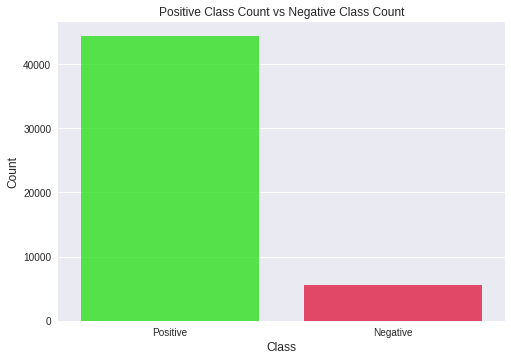

Positive    44377
Negative     5623
Name: Score, dtype: int64


In [14]:
# Checking the number of positive and negative reviews

Class_Count  = final['Score'].value_counts()
#city_count = city_count[:10,]
plt.figure()
flatui = ["#15ff00", "#ff0033"]
sns.set_palette(flatui)
sns.barplot(Class_Count.index, Class_Count.values, alpha=0.8 )
plt.title('Positive Class Count vs Negative Class Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()

print(final['Score'].value_counts())

In [15]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [0]:
# Function to Remove HTML Tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner,"",sentence)
    return cleantext

In [0]:
# Function to clean punctuations and special characters

def cleanpunct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [18]:

# Initialize Stop words and PorterStemmer and Lemmetizer
stop = set(stopwords.words('english'))
sno = SnowballStemmer('english')


'''print(stop)
print('*' * 100)
print(sno.stem('tasty'))'''

"print(stop)\nprint('*' * 100)\nprint(sno.stem('tasty'))"

In [0]:
# Cleaning HTML and non-Alphanumeric characters from the review text
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [20]:
final['CleanedText']=final_string
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


**4.  KNN with KD Tree and Brute Force Algorithm**

In [0]:
# Container to store the results

final_results = {}

In [0]:

# Function for Decision Tree
def runDT(X_Train,X_Test,y_train,y_test,VectorizationType):
  depth = []
  score = []
  
  
  
  
  for i in range(2,20):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    # Perform 7-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X_Train, y=y_train, cv=7, n_jobs=4)
    depth.append(i)
    score.append(scores.mean()*100)
    print('For depth: ',i,'CV Score is:',scores.mean())
  #print(depth)
    
    
  plt.plot(depth,score,'.-')
  plt.title('Tree Depth vs CV Scores')
  plt.ylabel('CV Scores')
  plt.xlabel('Tree Depth')
  plt.show()
  
  #print(depth)
  #print(score)
  #print(depth[score.index(max(score))])

  
  
  max_depth_optimum = depth[score.index(max(score))]
  #print(max_depth_optimum)
  gini = tree.DecisionTreeClassifier(criterion='gini',max_depth= max_depth_optimum,random_state= 0)
  gini.fit(X_Train,y_train)
  pred = gini.predict(X_Test)
  
  
  print('\nDetails for ',VectorizationType,'Vectorization:')
  print('*'*100)
  print('Accuracy for Gini Criteria algorithm with Tree Depth =',max_depth_optimum,' is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
  print('F1 score for Gini Criteria algorithm with Tree Depth =',max_depth_optimum,' is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
  print('Recall for Gini Criteria algorithm with Tree Depth =',max_depth_optimum,' is '  , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
  print('Precision for Gini Criteria algorithm with Tree Depth =',max_depth_optimum,' is '  , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
  print ('\n Classification report for Gini Criteria algorithm with Tree Depth =',max_depth_optimum,' is \n'  , classification_report(y_test,pred))
    

    
  plt.figure()
  confusion_matrix_Plot = confusion_matrix(y_test,pred)
  heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  
  
  
  y_pred = gini.predict(X_Test)
  print('The Accuracy of Decision Tree Algorithm with tree depth = ',max_depth_optimum,'and ',VectorizationType,
        ' vectorization is: ',accuracy_score(y_test,y_pred)*100)
  final_results[VectorizationType] =accuracy_score(y_test,y_pred)*100
  
 

**4.3 Using Average Word2Vec**

In [0]:
#Splitting into TRaining and Testing Set, and using only Training set for Word2Vec Training
X_Train,X_Test,y_train,y_test = train_test_split(final['Text'],final['Score'])


# Train your own Word2Vec model using your own text corpus

i=0
list_of_sent=[]
for sent in X_Train.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [25]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
words = list(w2v_model.wv.vocab)
print(len(words))


11978


37500
12500
For depth:  2 CV Score is: 0.8868000023611431
For depth:  3 CV Score is: 0.8865600158694292
For depth:  4 CV Score is: 0.8862666697365505
For depth:  5 CV Score is: 0.8854400009333084
For depth:  6 CV Score is: 0.8843999682221215
For depth:  7 CV Score is: 0.8832266284846357
For depth:  8 CV Score is: 0.8796532794936992
For depth:  9 CV Score is: 0.8765065737077115
For depth:  10 CV Score is: 0.8736532688028581
For depth:  11 CV Score is: 0.8709065886151638
For depth:  12 CV Score is: 0.8646932538332912
For depth:  13 CV Score is: 0.8609065907055519
For depth:  14 CV Score is: 0.855813250951343
For depth:  15 CV Score is: 0.849653335536005
For depth:  16 CV Score is: 0.843279971601781
For depth:  17 CV Score is: 0.8384265486596876
For depth:  18 CV Score is: 0.8333065315734538
For depth:  19 CV Score is: 0.8265065592740803


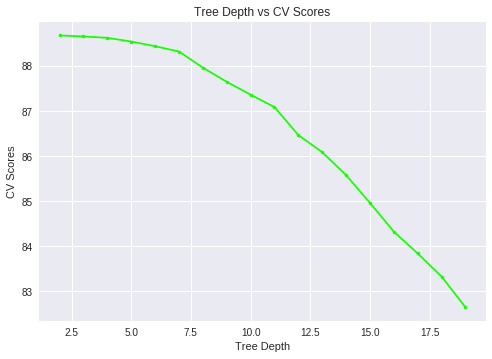


Details for  Average Word2Vec Vectorization:
****************************************************************************************************
Accuracy for Gini Criteria algorithm with Tree Depth = 2  is  88.96
F1 score for Gini Criteria algorithm with Tree Depth = 2  is  47.08
Recall for Gini Criteria algorithm with Tree Depth = 2  is  50.0
Precision for Gini Criteria algorithm with Tree Depth = 2  is  44.48

 Classification report for Gini Criteria algorithm with Tree Depth = 2  is 
              precision    recall  f1-score   support

   Negative       0.00      0.00      0.00      1380
   Positive       0.89      1.00      0.94     11120

avg / total       0.79      0.89      0.84     12500

The Accuracy of Decision Tree Algorithm with tree depth =  2 and  Average Word2Vec  vectorization is:  88.96


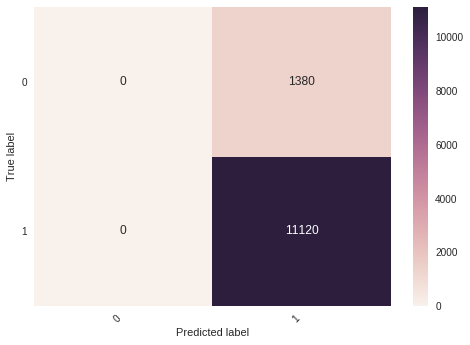

In [26]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_Train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_train_Vectorised = sent_vectors



sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_Test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_test_Vectorised = sent_vectors
print(len(X_train_Vectorised))
print(len(X_test_Vectorised))

#X_1, X_test, y_1, y_test = cross_validation.train_test_split(sent_vectors, final['Score'], random_state = 0,test_size = 0.3)
#print('X_train first entry: \n\n', X_1[0])
#print('\n\nX_train shape: ', X_1.shape)

# split the train data set into cross validation train and cross validation test
#X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

np.where(np.isnan(X_test_Vectorised))
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)
#np.nan_to_num(X_test_Vectorised)

runDT(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'Average Word2Vec')

**4.4 Using TF-IDF Weighted Word2Vec**

For depth:  2 CV Score is: 0.8868533371167365
For depth:  3 CV Score is: 0.8868533371167365
For depth:  4 CV Score is: 0.8868533371167365
For depth:  5 CV Score is: 0.8868533371167365
For depth:  6 CV Score is: 0.8868533371167365
For depth:  7 CV Score is: 0.8868533371167365
For depth:  8 CV Score is: 0.8868533371167365
For depth:  9 CV Score is: 0.8868533371167365
For depth:  10 CV Score is: 0.8868533371167365
For depth:  11 CV Score is: 0.8868533371167365
For depth:  12 CV Score is: 0.8868533371167365
For depth:  13 CV Score is: 0.8868533371167365
For depth:  14 CV Score is: 0.8868533371167365
For depth:  15 CV Score is: 0.8868533371167365
For depth:  16 CV Score is: 0.8868533371167365
For depth:  17 CV Score is: 0.8868533371167365
For depth:  18 CV Score is: 0.8868533371167365
For depth:  19 CV Score is: 0.8868533371167365


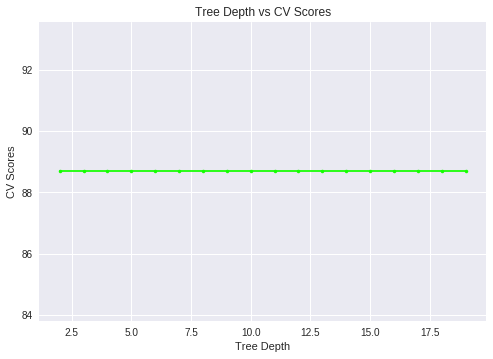


Details for  TF-IDF Weighted Word2Vec Vectorization:
****************************************************************************************************
Accuracy for Gini Criteria algorithm with Tree Depth = 2  is  88.96
F1 score for Gini Criteria algorithm with Tree Depth = 2  is  47.08
Recall for Gini Criteria algorithm with Tree Depth = 2  is  50.0
Precision for Gini Criteria algorithm with Tree Depth = 2  is  44.48

 Classification report for Gini Criteria algorithm with Tree Depth = 2  is 
              precision    recall  f1-score   support

   Negative       0.00      0.00      0.00      1380
   Positive       0.89      1.00      0.94     11120

avg / total       0.79      0.89      0.84     12500

The Accuracy of Decision Tree Algorithm with tree depth =  2 and  TF-IDF Weighted Word2Vec  vectorization is:  88.96


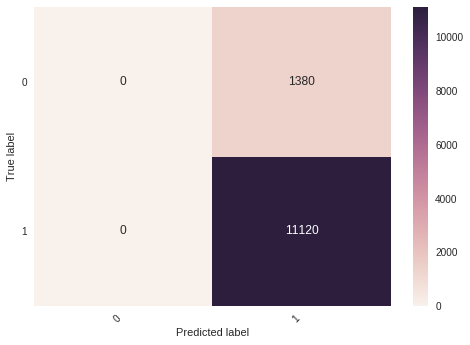

In [27]:
# TF-IDF weighted Word2Vec
vect_tfidf = TfidfVectorizer(min_df = 5).fit(X_Train)
tfidf_feat = vect_tfidf.get_feature_names() # tfidf words/col-names
#print(tfidf_feat)
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_Train: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = vect_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    
    #print(type(sent_vec))
    try:
        sent_vec /= weight_sum
    except:
        pass
    
    tfidf_sent_vectors.append(sent_vec)
    row += 1
X_train_Vectorised = tfidf_sent_vectors


tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in X_Test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = vect_tfidf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    
    #print(type(sent_vec))
    try:
        sent_vec /= weight_sum
    except:
        pass
    
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_test_Vectorised = tfidf_sent_vectors
    
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)
    
runDT(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'TF-IDF Weighted Word2Vec')
    

  **Conclusion**

In [28]:
print('The Accuracy using Average Word2Vec vectorization is:',final_results['Average Word2Vec'])
print('The Accuracy using TF-IDF Weighted Word2Vec vectorization is:',final_results['TF-IDF Weighted Word2Vec'])

The Accuracy using Average Word2Vec vectorization is: 88.96
The Accuracy using TF-IDF Weighted Word2Vec vectorization is: 88.96


**It is seen that the accuracy for both  Average Word2Vec and TF-IDF Weighted Word2Vec vectorization while using Decision Trees with Gini Criterion is 88.96%**